# LRNN Classifier Tutorial — ListOps

This notebook demonstrates the `Classifier` architecture from `lrnnx` on the ListOps task. 

1. Input & tokenization: raw ListOps expressions are tokenized into IDs (digits, brackets, and operators) and padded/truncated to a fixed length. Shape: `(B, L, E)` where `B` = batch, `L` = sequence length, `E` = embedding size.

2. Embedding: token IDs are mapped to continuous vectors via an embedding layer.

3. Per-block processing: the Classifier is a stack of blocks. Each block runs an LRNN mixer over the sequence positions and then applies a residual connection, LayerNorm, and dropout. 

4. Intermediate pooling (optional): between blocks the model can apply pooling (`stride` / `mean` / `max`) to aggregate nearby tokens. Pooling shortens the sequence length `L -> L'`.

5. Hybrid stacks: the `lrnn_cls` argument accepts either a single LRNN class for all blocks or a list of LRNN classes to construct heterogeneous layers (e.g., `[LRU, S5, Centaurus]`). This enables mixing different models across depth.

6. Final collapse & head: after the final block the sequence is collapsed to a single vector per example using a pooling mode (`last`, `mean`, or `max`), producing `(B, E)`. A linear classification head maps this vector to logits `(B, num_classes)` for prediction.


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

from lrnnx.architectures.classifier import Classifier
from lrnnx.models.lti.lru import LRU

# -------------------
# Global configuration
# -------------------
# General
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Single-model hyperparameters
EMBEDDING_DIM = 128
D_MODEL = 512
D_STATE = 256
N_LAYERS = 6

# Multi-model (hybrid) hyperparameters
MULTI_EMBEDDING_DIM = 64
MULTI_D_MODEL = 256
MULTI_D_STATE = 128
MULTI_NUM_EPOCHS = 25


/media/aarush1729/0F6307FC0F6307FC/lrnnx/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset

We use the **ListOps-1000** dataset from Hugging Face. This contains mathematical expressions with nested operations (MAX, MIN, MED, SUM) that need to be evaluated.

In [2]:
 
# Load ListOps from Hugging Face datasets
print("Loading ListOps dataset from Hugging Face...")
ds = load_dataset("fengyang0317/listops-1000")
print("Dataset loaded!")

Loading ListOps dataset from Hugging Face...
Dataset loaded!
Dataset loaded!


## Create a Subset 

For faster experimentation, we use a small fraction of the data. Adjust `subset_fraction` to use more data for better results.


In [3]:
# Using x percent of dataset
subset_fraction = 0.01

ds_subset = {}
for split in ds.keys():
    # Get the total number of examples in the split
    total_examples = len(ds[split])
    # Calculate the number of examples for the subset
    subset_size = int(total_examples * subset_fraction)
    # Generate random indices
    indices = np.random.choice(total_examples, subset_size, replace=False)
    # Create the new subset
    ds_subset[split] = ds[split].select(indices)

# Inspect the new subset sizes
print(f"Train subset size: {len(ds_subset['train'])}")
print(f"Validation subset size: {len(ds_subset['validation'])}")
print(f"Test subset size: {len(ds_subset['test'])}")

# Look at the first example
print("\nExample from dataset:")
print(ds['train'][0])



Train subset size: 960
Validation subset size: 20
Test subset size: 20

Example from dataset:
{'Source': '( ( ( ( ( ( ( ( ( ( [MIN 1 ) ( ( ( ( ( ( ( ( [MED 8 ) 0 ) 1 ) 3 ) 0 ) 6 ) 1 ) ] ) ) 7 ) ( ( ( ( ( ( ( ( [MED ( ( ( ( ( ( ( ( ( [SM 4 ) ( ( ( ( ( ( ( [MED ( ( ( ( ( ( ( ( ( [SM 2 ) 9 ) ( ( ( ( ( ( ( [MED 9 ) 9 ) 2 ) ( ( ( ( ( ( ( ( ( ( ( [MIN 8 ) 3 ) 5 ) 4 ) 8 ) 5 ) 6 ) 2 ) 6 ) 0 ) ] ) ) 5 ) 8 ) ] ) ) 2 ) 6 ) 8 ) 9 ) 8 ) ] ) ) 3 ) 4 ) ( ( ( ( ( ( [SM 3 ) ( ( ( ( ( ( ( [SM ( ( ( ( ( ( ( [MIN ( ( ( ( ( ( ( ( ( [MIN ( ( ( ( ( ( ( ( [MED 5 ) 8 ) 7 ) 9 ) 1 ) 7 ) 1 ) ] ) ) 8 ) 8 ) ( ( ( [MAX 2 ) 5 ) ] ) ) 7 ) 1 ) 1 ) 0 ) ] ) ) ( ( ( ( ( ( [MAX 6 ) 2 ) 5 ) 0 ) ( ( ( ( ( ( ( [MIN 2 ) 2 ) 4 ) 8 ) 7 ) 1 ) ] ) ) ] ) ) ( ( ( ( ( ( [MIN 1 ) ( ( ( ( ( ( [SM 3 ) 6 ) 4 ) 0 ) 5 ) ] ) ) 5 ) ( ( ( ( [MED 6 ) 3 ) 8 ) ] ) ) 0 ) ] ) ) 5 ) 6 ) 4 ) ] ) ) 3 ) 7 ) 8 ) 0 ) 6 ) ] ) ) 8 ) 8 ) 3 ) ] ) ) ( ( ( ( ( [MAX 5 ) 1 ) 3 ) 5 ) ] ) ) ( ( ( ( ( ( ( ( ( [MED 3 ) ( ( ( ( ( [SM 3 ) 2 ) 6 ) ( ( ( ( ( ( ( ( ( ( 

## Tokenization and DataLoader

### ListOps Vocabulary
| Token | ID | Description |
|-------|-----|-------------|
| `[PAD]` | 0 | Padding token |
| `[` | 1 | Open bracket |
| `]` | 2 | Close bracket |
| `MAX` | 3 | Maximum operation |
| `MIN` | 4 | Minimum operation |
| `MED` | 5 | Median operation |
| `SUM` | 6 | Sum modulo 10 |
| `0-9` | 7-16 | Digit tokens |


In [4]:
LISTOPS_VOCAB_SIZE = 20  # pad + [ + ] + MAX/MIN/MED/SUM + digits 0-9 + special tokens
LISTOPS_NUM_CLASSES = 10  # Output classes 0-9
LISTOPS_MAX_LEN = 200 # 2000->200

# Create tokenizer for ListOps
class ListOpsTokenizer:
    def __init__(self):
        self.token_map = {
            "[PAD]": 0,
            "[": 1,
            "]": 2,
            "MAX": 3,
            "MIN": 4,
            "MED": 5,
            "SUM": 6
        }
        # Add digits to token map
        for i in range(10):
            self.token_map[str(i)] = 7 + i
    
    def tokenize(self, sequence, max_length):
        """Convert a ListOps sequence to token IDs"""
        tokens = []
        for token in sequence.split():
            if token in self.token_map:
                tokens.append(self.token_map[token])
            else:
                # Maybe put some error/assert message?
                continue
        
        # Get sequence length
        seq_len = len(tokens)
        
        # Pad or truncate sequence
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
            seq_len = max_length
        else:
            tokens = tokens + [0] * (max_length - len(tokens))
        
        return tokens, seq_len

# Create PyTorch dataset from Hugging Face dataset
class HFListOpsDataset(Dataset):
    def __init__(self, hf_dataset, split, max_length=LISTOPS_MAX_LEN):
        self.data = hf_dataset[split]
        self.tokenizer = ListOpsTokenizer()
        self.max_length = max_length
        
        # Process all data at once
        self.tokens = []
        self.labels = []
        self.lengths = []
        
        print(f"Processing {split} dataset...")
        for example in tqdm(self.data):
            tokens, seq_len = self.tokenizer.tokenize(
                example['Source'], self.max_length
            )
            self.tokens.append(tokens)
            self.labels.append(int(example['Target']))  # Convert label to int
            self.lengths.append(seq_len)
        
        print(f"Processed {len(self.labels)} examples.")
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.tokens[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long),
            torch.tensor(self.lengths[idx], dtype=torch.long)
        )

# Create datasets and dataloaders
train_dataset = HFListOpsDataset(ds_subset, 'train', max_length=LISTOPS_MAX_LEN)
val_dataset = HFListOpsDataset(ds_subset, 'validation', max_length=LISTOPS_MAX_LEN)
test_dataset = HFListOpsDataset(ds_subset, 'test', max_length=LISTOPS_MAX_LEN)

# Use configured batch size
batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Processing train dataset...


100%|██████████| 960/960 [00:00<00:00, 1387.46it/s]


Processed 960 examples.
Processing validation dataset...


100%|██████████| 20/20 [00:00<00:00, 2535.47it/s]


Processed 20 examples.
Processing test dataset...


100%|██████████| 20/20 [00:00<00:00, 1951.57it/s]

Processed 20 examples.


## LRNN Constructor Parameters Reference

When instantiating a `Classifier`, the `lrnn_params` argument must contain the exact constructor arguments for your chosen `lrnn_cls`. Below is a reference for each supported LRNN architecture:

| Model | `lrnn_params` |
|-------|---------------|
| **LRU** | `{"H": d_model, "N": d_state}` |
| **S5** | `{"hid_dim": d_model, "state_dim": d_state, "discretization": "zoh"}` |
| **Centaurus** | `{"d_model": d_model, "state_dim": d_state, "sub_state_dim": d_state}` |


In [5]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use configured hyperparameters
n_layers = N_LAYERS

# Create LRNN classifier model
# Note: lrnn_params must contain the exact constructor args for the chosen lrnn_cls.
# For LRU:      {"H": d_model, "N": d_state}
# For S5:       {"hid_dim": d_model, "state_dim": d_state, "discretization": "zoh"}
# For Centaurus: {"d_model": d_model, "state_dim": d_state, "sub_state_dim": d_state}
model = Classifier(
    input_dim = None, # Not Needed with embeddings
    num_classes=LISTOPS_NUM_CLASSES,
    vocab_size=LISTOPS_VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    max_position_embeddings=LISTOPS_MAX_LEN,
    padding_idx=0,
    d_model=D_MODEL,
    d_state=D_STATE,
    n_layers=n_layers,
    lrnn_cls=LRU,
    lrnn_params={"H": D_MODEL, "N": D_STATE},  # LRU constructor args
    dropout=0.1,
    pooling="last",  
    intermediate_pooling=["none"] * n_layers,  
).to(device)

# Print model summary
print("\nClassifier for ListOps")
print(f"Vocabulary size: {LISTOPS_VOCAB_SIZE}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass with a single batch
tokens, labels, lengths = next(iter(train_loader))
tokens, labels, lengths = tokens.to(device), labels.to(device), lengths.to(device)

print("\nInput shapes:")
print(f"Tokens: {tokens.shape}")
print(f"Labels: {labels.shape}")
print(f"Lengths: {lengths.shape}")

outputs = model(tokens, lengths=lengths)
print(f"Output shape: {outputs.shape}")

# Set up training
num_epochs = NUM_EPOCHS
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1, betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop
best_acc = 0.0
single_train_losses = []
single_val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for tokens, labels, lengths in progress_bar:
        # Move to device
        tokens = tokens.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(tokens, lengths=lengths)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update weights
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    # Calculate epoch loss
    epoch_loss = running_loss / len(train_loader)
    single_train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for tokens, labels, lengths in tqdm(val_loader, desc="Validation"):
            tokens = tokens.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            outputs = model(tokens, lengths=lengths)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    val_acc = 100.0 * correct / total
    single_val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': best_acc
        }, "best_listops_model.pt")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")
    
    # Update learning rate
    scheduler.step()

print(f"Training complete! Best validation accuracy: {best_acc:.2f}%")

Using device: cpu

Classifier for ListOps
Vocabulary size: 20
Total parameters: 3,233,290

Input shapes:
Tokens: torch.Size([32, 200])
Labels: torch.Size([32])
Lengths: torch.Size([32])
Output shape: torch.Size([32, 10])
Output shape: torch.Size([32, 10])


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]



Epoch 1 - Loss: 2.4323, Val Acc: 5.00%
New best model saved with accuracy: 5.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



Epoch 2 - Loss: 2.0927, Val Acc: 15.00%
New best model saved with accuracy: 15.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 3 - Loss: 1.8810, Val Acc: 15.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 4 - Loss: 1.6086, Val Acc: 10.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 5 - Loss: 1.3925, Val Acc: 15.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 6 - Loss: 1.2122, Val Acc: 10.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 7 - Loss: 1.0666, Val Acc: 10.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 8 - Loss: 0.9446, Val Acc: 10.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 9 - Loss: 0.8788, Val Acc: 10.00%


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

Epoch 10 - Loss: 0.8299, Val Acc: 10.00%
Training complete! Best validation accuracy: 15.00%


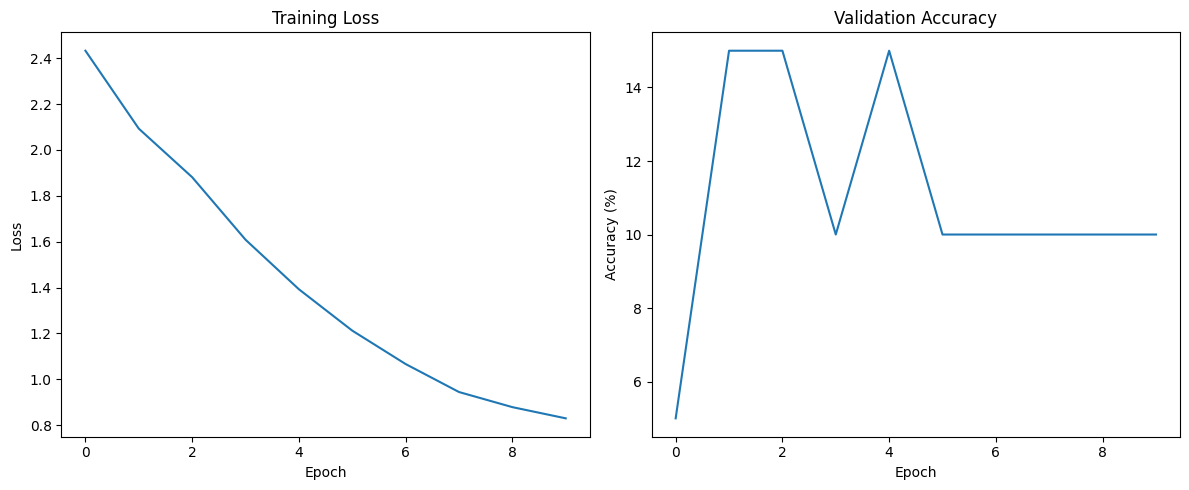


Evaluating on test set...


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Test accuracy: 10.00%


In [6]:
# Plot training curves (single-model run)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(single_train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(single_val_accs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Final evaluation on test set
print("\nEvaluating on test set...")
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for tokens, labels, lengths in tqdm(test_loader):
        tokens = tokens.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        outputs = model(tokens, lengths=lengths)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100.0 * correct / total
print(f"Test accuracy: {test_acc:.2f}%")


## Advanced: Multi-Model Architecture 

The `Classifier` supports **heterogeneous architectures** — you can use different LRNN models in different layers to allow hybrid design combinations!

### How It Works

```python
# Single model (traditional)
lrnn_cls=LRU  # Same model for all layers

# Multiple models 
lrnn_cls=[LRU, Centaurus, S5, LRU]  # Different per layer
```

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from lrnnx.architectures.classifier import Classifier
from lrnnx.models.lti.s5 import S5

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Define Multi-Layer Classifier ---
# lrnn_params must contain the exact constructor args for the chosen lrnn_cls.
# For LRU:      {"H": d_model, "N": d_state}
# For S5:       {"hid_dim": d_model, "state_dim": d_state, "discretization": "zoh"}
# For Centaurus: {"d_model": d_model, "state_dim": d_state, "sub_state_dim": d_state}

n_layers_multi = 4

model = Classifier(
    input_dim=None,
    num_classes=LISTOPS_NUM_CLASSES,
    vocab_size=LISTOPS_VOCAB_SIZE,
    embedding_dim=MULTI_EMBEDDING_DIM,
    max_position_embeddings=LISTOPS_MAX_LEN,
    padding_idx=0,
    d_model=MULTI_D_MODEL,
    d_state=MULTI_D_STATE,
    n_layers=n_layers_multi,
    lrnn_cls=S5,  # Use S5 for all layers
    lrnn_params={"hid_dim": MULTI_D_MODEL, "state_dim": MULTI_D_STATE, "discretization": "zoh"},
    dropout=0.1,
    pooling="mean",
).to(device)

print(f"S5 Model Created with {n_layers_multi} layers")
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

# --- 3. Optimizer ---
num_epochs = MULTI_NUM_EPOCHS
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# --- 4. Training Loop ---
multi_train_losses = []
multi_val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for tokens, labels, lengths in pbar:
        tokens, labels, lengths = tokens.to(device), labels.to(device), lengths.to(device)
        
        optimizer.zero_grad()
        outputs = model(tokens, lengths=lengths)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    # Calculate epoch loss (average over batches)
    epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0.0
    multi_train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for tokens, labels, lengths in val_loader:
            tokens, labels, lengths = tokens.to(device), labels.to(device), lengths.to(device)
            outputs = model(tokens, lengths=lengths)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            
    val_acc = 100 * correct / total if total > 0 else 0.0
    multi_val_accs.append(val_acc)
    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}%")

Using device: cpu
S5 Model Created with 4 layers
Params: 679,434


Epoch 1:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s, loss=2.1505]



Epoch 1 | Loss: 2.2626 | Val Acc: 10.00%


Epoch 2: 100%|██████████| 30/30 [00:20<00:00,  1.45it/s, loss=2.2020]



Epoch 2 | Loss: 2.2416 | Val Acc: 10.00%


Epoch 3: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, loss=2.1473]



Epoch 3 | Loss: 2.2293 | Val Acc: 10.00%


Epoch 4: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s, loss=2.3624]



Epoch 4 | Loss: 2.2298 | Val Acc: 10.00%


Epoch 5: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, loss=2.2022]



Epoch 5 | Loss: 2.2229 | Val Acc: 15.00%


Epoch 6: 100%|██████████| 30/30 [00:18<00:00,  1.59it/s, loss=2.1571]



Epoch 6 | Loss: 2.2184 | Val Acc: 10.00%


Epoch 7: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=2.3015]



Epoch 7 | Loss: 2.2175 | Val Acc: 20.00%


Epoch 8: 100%|██████████| 30/30 [00:18<00:00,  1.63it/s, loss=2.1980]



Epoch 8 | Loss: 2.2218 | Val Acc: 10.00%


Epoch 9: 100%|██████████| 30/30 [00:17<00:00,  1.73it/s, loss=2.1664]



Epoch 9 | Loss: 2.2181 | Val Acc: 20.00%


Epoch 10: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=2.3222]



Epoch 10 | Loss: 2.2118 | Val Acc: 15.00%


Epoch 11: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=2.1296]



Epoch 11 | Loss: 2.2050 | Val Acc: 20.00%


Epoch 12: 100%|██████████| 30/30 [00:16<00:00,  1.78it/s, loss=2.3485]



Epoch 12 | Loss: 2.2099 | Val Acc: 10.00%


Epoch 13: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s, loss=2.2088]



Epoch 13 | Loss: 2.2016 | Val Acc: 15.00%


Epoch 14: 100%|██████████| 30/30 [00:15<00:00,  1.90it/s, loss=2.2846]



Epoch 14 | Loss: 2.2002 | Val Acc: 10.00%


Epoch 15: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s, loss=2.2236]



Epoch 15 | Loss: 2.1946 | Val Acc: 5.00%


Epoch 16: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s, loss=2.2628]



Epoch 16 | Loss: 2.1901 | Val Acc: 10.00%


Epoch 17: 100%|██████████| 30/30 [00:19<00:00,  1.58it/s, loss=2.2115]



Epoch 17 | Loss: 2.1798 | Val Acc: 5.00%


Epoch 18: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s, loss=2.2585]



Epoch 18 | Loss: 2.1829 | Val Acc: 5.00%


Epoch 19: 100%|██████████| 30/30 [00:17<00:00,  1.69it/s, loss=2.1295]



Epoch 19 | Loss: 2.1771 | Val Acc: 10.00%


Epoch 20: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s, loss=2.1421]



Epoch 20 | Loss: 2.1711 | Val Acc: 10.00%


Epoch 21: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s, loss=2.1526]



Epoch 21 | Loss: 2.1685 | Val Acc: 10.00%


Epoch 22: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s, loss=2.1340]



Epoch 22 | Loss: 2.1647 | Val Acc: 10.00%


Epoch 23: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s, loss=2.2751]



Epoch 23 | Loss: 2.1630 | Val Acc: 10.00%


Epoch 24: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s, loss=2.1816]



Epoch 24 | Loss: 2.1615 | Val Acc: 10.00%


Epoch 25: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=2.2669]

Epoch 25 | Loss: 2.1606 | Val Acc: 10.00%


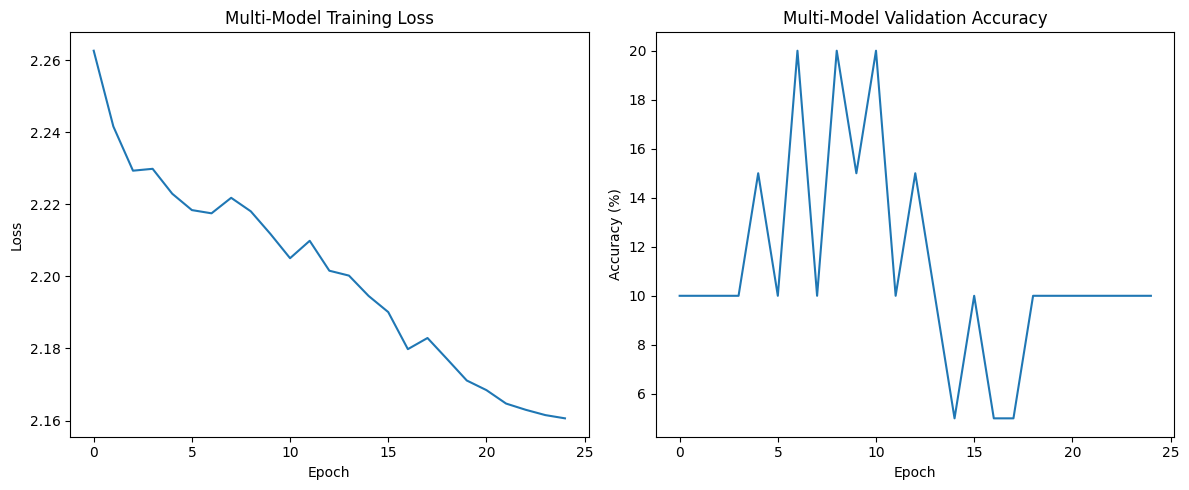

In [8]:
# Plot multi-model training curves (prefer multi-model history)
import matplotlib.pyplot as plt

# Prefer multi-model-specific history variables when present
train_list = globals().get('multi_train_losses') or globals().get('train_losses') or globals().get('train_loss_history') or []
val_list = globals().get('multi_val_accs') or globals().get('val_accs') or globals().get('val_acc_history') or []

if len(train_list) and len(val_list):
    # Ensure both lists have the same length for plotting
    min_len = min(len(train_list), len(val_list))
    train_plot = train_list[:min_len]
    val_plot = val_list[:min_len]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_plot)
    plt.title('Multi-Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(val_plot)
    plt.title('Multi-Model Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()
else:
    print("No multi-model history found. Ensure the multi-model training loop appends to 'multi_train_losses' and 'multi_val_accs' and re-run the training cell.")